#### **Problem Formulation**

Our Dataset: (https://www.kaggle.com/datasets/ronaldonyango/global-suicide-rates-1990-to-2022) 

##### Our Question: What `socioeconomic factors` might be behind the suicide rates in the world ?


#### Import dependencies


In [1]:
import numpy as np
import math
import matplotlib.gridspec as gridspec
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
from sklearn.linear_model import LinearRegression
sb.set() # set the default Seaborn style for graphics
import plotly.express as px

In [2]:
data = pd.read_csv('age_std_suicide_rates_1990-2022.csv')
data.head()

RegionCode RegionName CountryCode CountryName  Year     Sex  SuicideCount  \
0         EU     Europe         ALB     Albania  1992    Male            33   
1         EU     Europe         ALB     Albania  1992  Female            14   
2         EU     Europe         ALB     Albania  1993    Male            46   
3         EU     Europe         ALB     Albania  1993  Female            27   
4         EU     Europe         ALB     Albania  1994    Male            37   

   CauseSpecificDeathPercentage  StdDeathRate  DeathRatePer100K  Population  \
0                      0.331959      2.335802          2.076386   3247039.0   
1                      0.191860      0.866420          0.874563   3247039.0   
2                      0.477724      3.330938          2.937233   3227287.0   
3                      0.385164      1.755077          1.686025   3227287.0   
4                      0.419406      2.678796          2.332619   3207536.0   

            GDP  GDPPerCapita           GNI  GNIPerCapita  InflationRate  \
0  6.521750e+08    200.852220  9.061842e+08        1740.0     226.005421   
1  6.521750e+08    200.852220  9.061842e+08        1740.0     226.005421   
2  1.185315e+09    367.279225  1.024263e+09        2110.0      85.004751   
3  1.185315e+09    367.279225  1.024263e+09        2110.0      85.004751   
4  1.880951e+09    586.416135  1.216681e+09        2300.0      22.565053   

   EmploymentPopulationRatio  
0                     45.315  
1                     45.315  
2                     47.798  
3                     47.798  
4                     50.086

In [3]:
fig = px.choropleth(
    data,
    locations="CountryName",
    locationmode="country names",
    color="StdDeathRate",
    hover_name="CountryName",
    animation_frame="Year",
    range_color=[data["StdDeathRate"].min(), data["StdDeathRate"].max()],
    projection="orthographic",
    color_continuous_scale=px.colors.sequential.Plasma,
    scope="world",
    labels={
        "Year": "Year",
        "CountryName": "Country",
        "RegionName": "Continent",
        "CountryCode": "Country Code",
        "Population": "Population",
    },
    hover_data={
        "Year": True,
        "CountryCode": True,
        "RegionName": True,
        "Population": True,
    },height=800,
    width=800,
    title="Suicide Rate by country",
)

fig.update_layout(
    legend=dict(
        yanchor="bottom",
        y=0.01,
        xanchor="left",
        x=0.01
    )
)
fig.show()

<span style='font-size:xxx-large'>**Data Preparation & Cleaning**</span>

<span style='font-size:x-large'>**Preliminary Feature Selection**</span>



> select relevent variables to find which variable is the best predictor for suicide rate



In [4]:
# Selecting relevant variables for analysis
data = data[['RegionCode', 'Year', 'Sex', 'StdDeathRate',  'Population', 'GDPPerCapita',  'GNIPerCapita', 'InflationRate', 'EmploymentPopulationRatio']]
print("The shape of the dataset before cleaning", data.shape)
data = data.dropna()
data.isnull().values.any()
print("The shape of the new dataset",data.shape)
print("===============================")
data.info()

The shape of the dataset before cleaning (5928, 9)
The shape of the new dataset (4732, 9)
<class 'pandas.core.frame.DataFrame'>
Index: 4732 entries, 0 to 5371
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   RegionCode                 4732 non-null   object 
 1   Year                       4732 non-null   int64  
 2   Sex                        4732 non-null   object 
 3   StdDeathRate               4732 non-null   float64
 4   Population                 4732 non-null   float64
 5   GDPPerCapita               4732 non-null   float64
 6   GNIPerCapita               4732 non-null   float64
 7   InflationRate              4732 non-null   float64
 8   EmploymentPopulationRatio  4732 non-null   float64
dtypes: float64(6), int64(1), object(2)
memory usage: 369.7+ KB


In [5]:
def removeOutliers(dataSet, quantifier):
    q1 = dataSet[quantifier].quantile(0.25)
    q3 = dataSet[quantifier].quantile(0.75)

    IQR = q3 - q1

    lower_bound = q1 - 1.5 * IQR
    upper_bound= q3 + 1.5 * IQR
    cleanedDataset = dataSet[(dataSet[quantifier] >= lower_bound) & (dataSet[quantifier] <= upper_bound)]

    return cleanedDataset

`Outliers will be removed during EDA, the suicides vary by countries.`


In [6]:
#split data based on gender

#EU: Europe, AS: Asia, OA: Oceania, CSA: Central and South America, NAC: North America & Carribbean, AF: Africa
regioncode_map = {'EU': 0, 'AS':1, 'OA':2, 'NAC':3, 'CSA':4, 'AF':5}
data['RegionCode'] = data['RegionCode'].replace(regioncode_map)
data['RegionCode']=data['RegionCode'].astype('category')
#data.head()

sex_mapping = {'Male': 0, 'Female': 1}
data['Sex'] = data['Sex'].replace(sex_mapping)
maleData = data[data['Sex']==0]
femaleData = data[data['Sex']==1]

-------------------------------------------------------


<span style='font-size:xxx-large'>**Exploratory Data Analysis**</span>



Exploring StdDeathRate

In [7]:
data['StdDeathRate'].describe()

count    4732.000000
mean        9.722446
std        10.628128
min         0.000000
25%         2.638335
50%         6.164396
75%        13.169558
max        78.310807
Name: StdDeathRate, dtype: float64

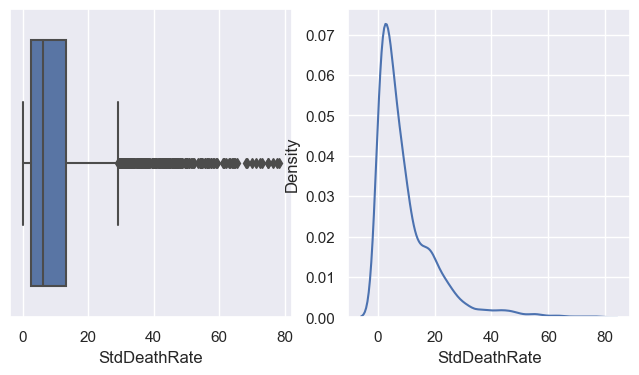

In [8]:
plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
sb.boxplot(data=data, x='StdDeathRate', orient='h')
plt.title='StdDeathRate'

plt.subplot(1,2,2)
sb.kdeplot(data=data, x='StdDeathRate')
plt.xlabel='StdDeathRate'

plt.show()

<span style='font-size:xx-large'>**Exploring GDPPerCapita**</span>

In [9]:
data['GDPPerCapita'].describe()

count      4732.000000
mean      19012.734814
std       20338.613578
min         157.063550
25%        4066.531738
50%       10842.208935
75%       27919.185500
max      133711.794400
Name: GDPPerCapita, dtype: float64

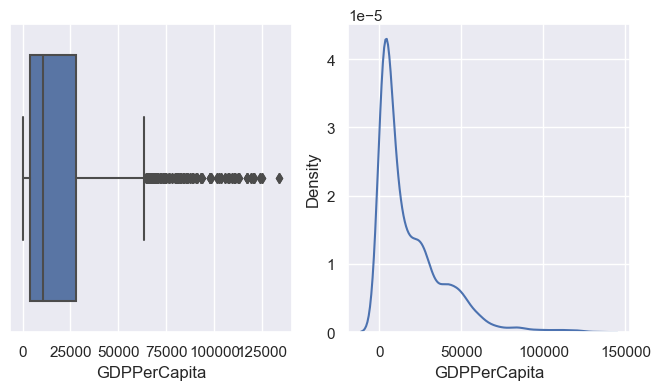

In [10]:
plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
sb.boxplot(data=data, x='GDPPerCapita', orient='h')
plt.title='GDPPerCapita'

plt.subplot(1,2,2)
sb.kdeplot(data=data, x='GDPPerCapita')
plt.xlabel='GDPPerCapita'

plt.show()


<span style='font-size:xx-large'>**Correlation Between all Variables**</span>

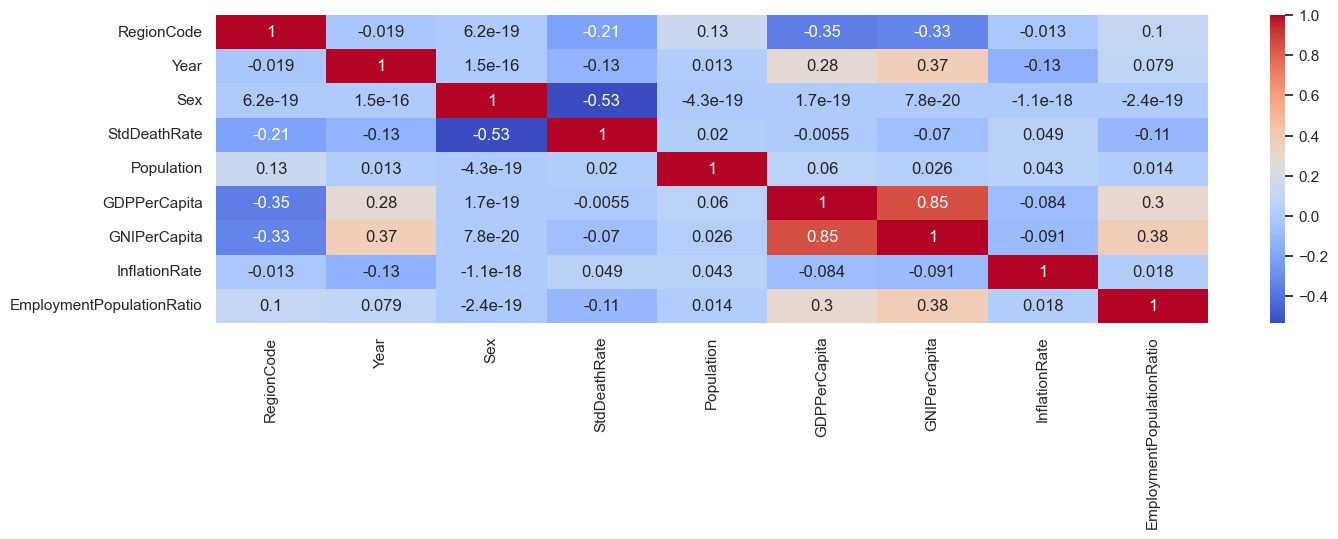

In [11]:
plt.figure(figsize=(16,4))
correlation_matrix = data.corr()
sb.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

<span style='font-size:xx-large'>**Sex is a Primary Factor in suicide**</span>


<span style='font-size:x-large'>**Exploring Relationship between Sex and Suicide Rate**</span>

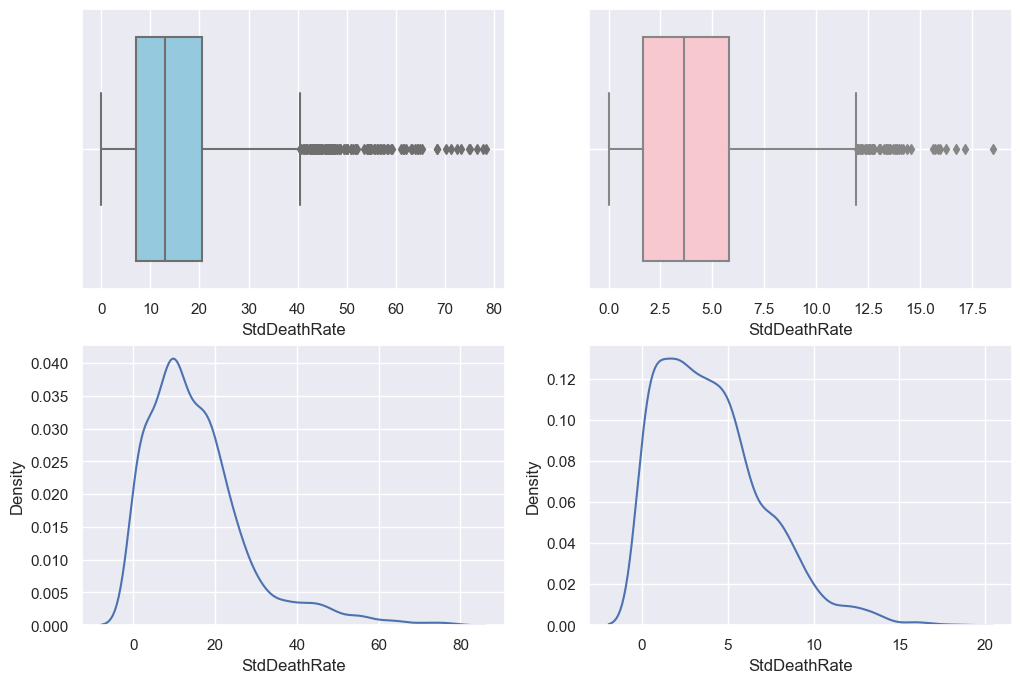

Male Suicide Data
count    2366.000000
mean       15.386219
std        12.341733
min         0.000000
25%         7.099932
50%        12.882924
75%        20.425168
max        78.310807
Name: StdDeathRate, dtype: float64
Female Suicide Data
count    2366.000000
mean        4.058674
std         3.075686
min         0.000000
25%         1.655984
50%         3.615216
75%         5.781007
max        18.502994
Name: StdDeathRate, dtype: float64


In [12]:

plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
sb.boxplot(x='StdDeathRate', data=maleData, color='skyblue')
#plt.xlabel('StdDeathRate')
#plt.title('Male Distribution of Suicides')
plt.grid(True)

plt.subplot(2,2,2)
sb.boxplot(x='StdDeathRate', data=femaleData, color='pink')
#plt.xlabel('StdDeathRate')
#plt.title('Male Distribution of Suicides')
plt.grid(True)

plt.subplot(2,2,3)
sb.kdeplot(data=maleData['StdDeathRate'])
#plt.xlabel('StdDeathRate of Males')

plt.subplot(2,2,4)
sb.kdeplot(data=femaleData['StdDeathRate'])
#plt.xlabel('StdDeathRate of Females')
plt.show()

print("Male Suicide Data")
print(maleData['StdDeathRate'].describe())
print("=================")
print("Female Suicide Data")
print(femaleData['StdDeathRate'].describe())


Correlation Split based on Sex

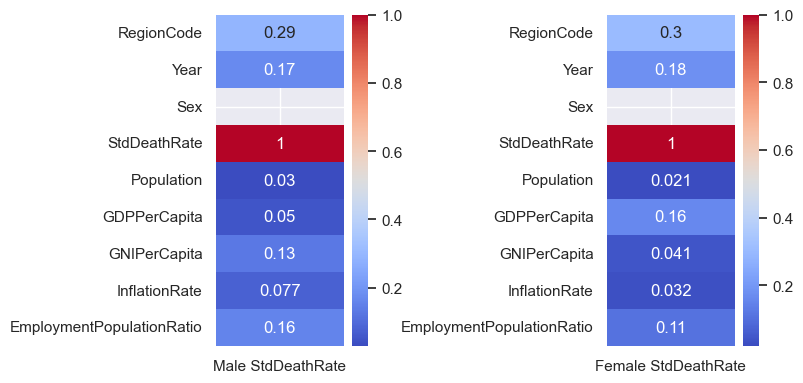

In [13]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
correlation_matrix = maleData.corr().abs()
correlation_matrix.rename(columns={'StdDeathRate': 'Male StdDeathRate'}, inplace=True)
sb.heatmap(correlation_matrix[['Male StdDeathRate']], annot=True, cmap='coolwarm')
plt.subplot(1,2,2)
correlation_matrix = femaleData.corr().abs()
correlation_matrix.rename(columns={'StdDeathRate': 'Female StdDeathRate'}, inplace=True)
sb.heatmap(correlation_matrix[['Female StdDeathRate']], annot=True, cmap='coolwarm')
plt.tight_layout()
plt.show()


Males:
Correlation between StdDeathRate and InflationRate, Population and GDPPerCapita is low. Can Explore GNIPerCapita for Males

Females:
Correlation between StdDeathRate and InflationRate, Population and GNIPerCapita is low. Can Explore GDPPerCapita for Females

Both:
Correlation Between StdDeathRate and Year, EmploymentPopulationRatio can be Explored


<span style='font-size:xx-large'>Exploring Year over Year trends of Relevant Columns</span>

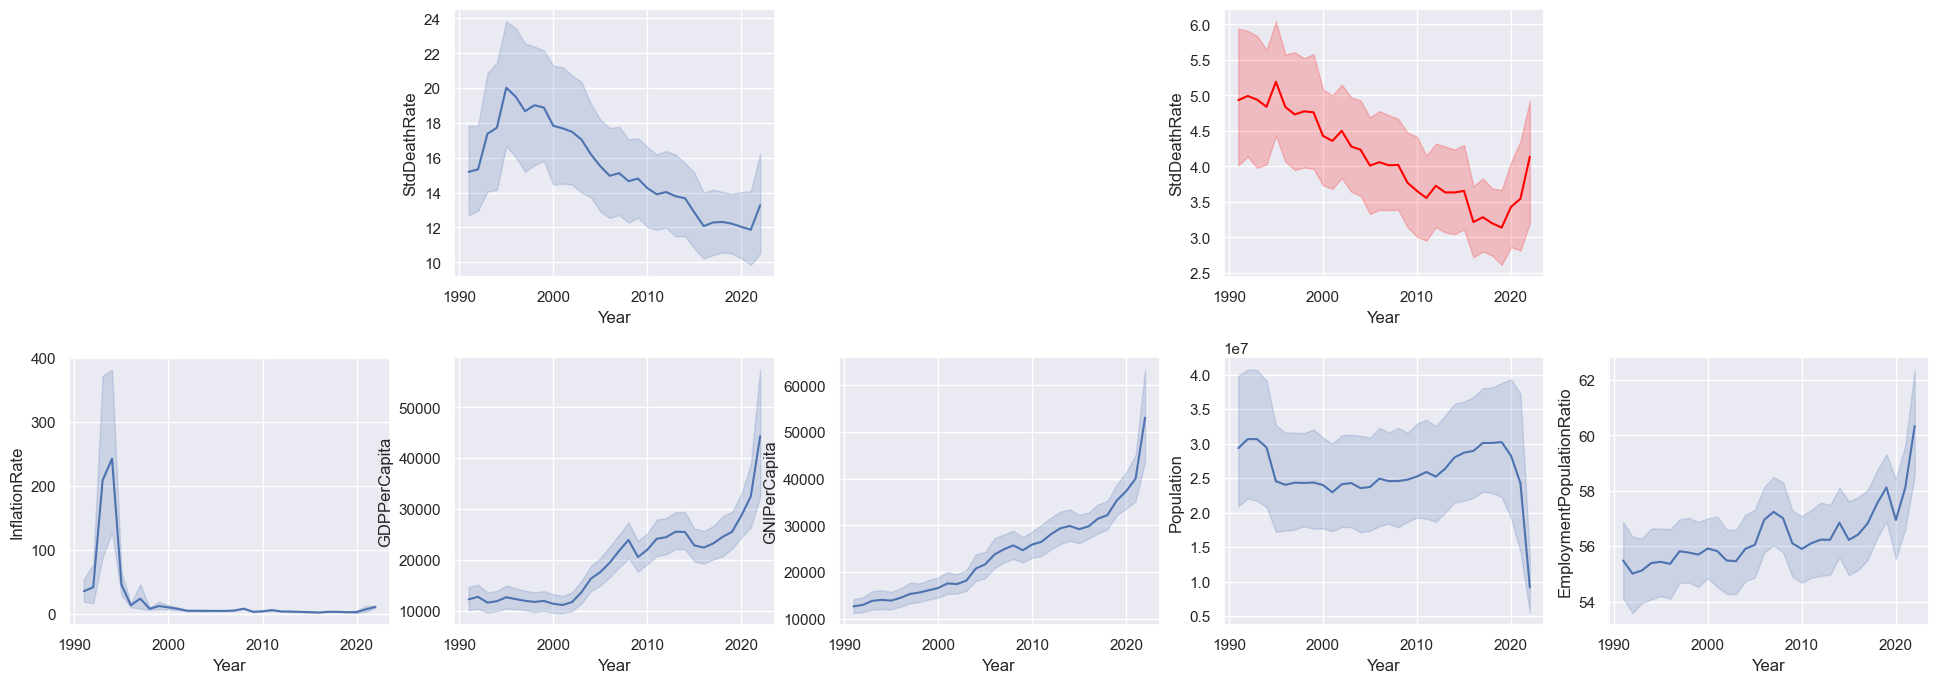

In [14]:
plt.figure(figsize=(24,8))
plt.subplot(2,5,2)
sb.lineplot(data=data[data['Sex']==0], x='Year', y='StdDeathRate')
plt.subplot(2,5,4)
sb.lineplot(data=data[data['Sex']==1], x='Year', y='StdDeathRate', color='red')
plt.subplot(2,5,6)
sb.lineplot(data, x='Year', y='InflationRate')
plt.subplot(2,5,7)
sb.lineplot(data, x='Year', y='GDPPerCapita')
plt.subplot(2,5,8)
sb.lineplot(data, x='Year', y='GNIPerCapita')
plt.subplot(2,5,9)
sb.lineplot(data, x='Year', y='Population')
plt.subplot(2,5,10)
sb.lineplot(data, x='Year', y='EmploymentPopulationRatio')

plt.subplots_adjust(hspace=0.3)

plt.show()

Trend of suicide Rates between Sex stays typically the same between both genders throughout the dataset's timespan.


<span style='font-size:xx-large'>**Exploring Region Code**</span>

Median GDPPerCapita for each RegionCode:
RegionCode
0    20930.398240
1    11040.151860
2    21967.746040
3    10432.379075
4     4647.807541
5     3914.262072
Name: GDPPerCapita, dtype: float64


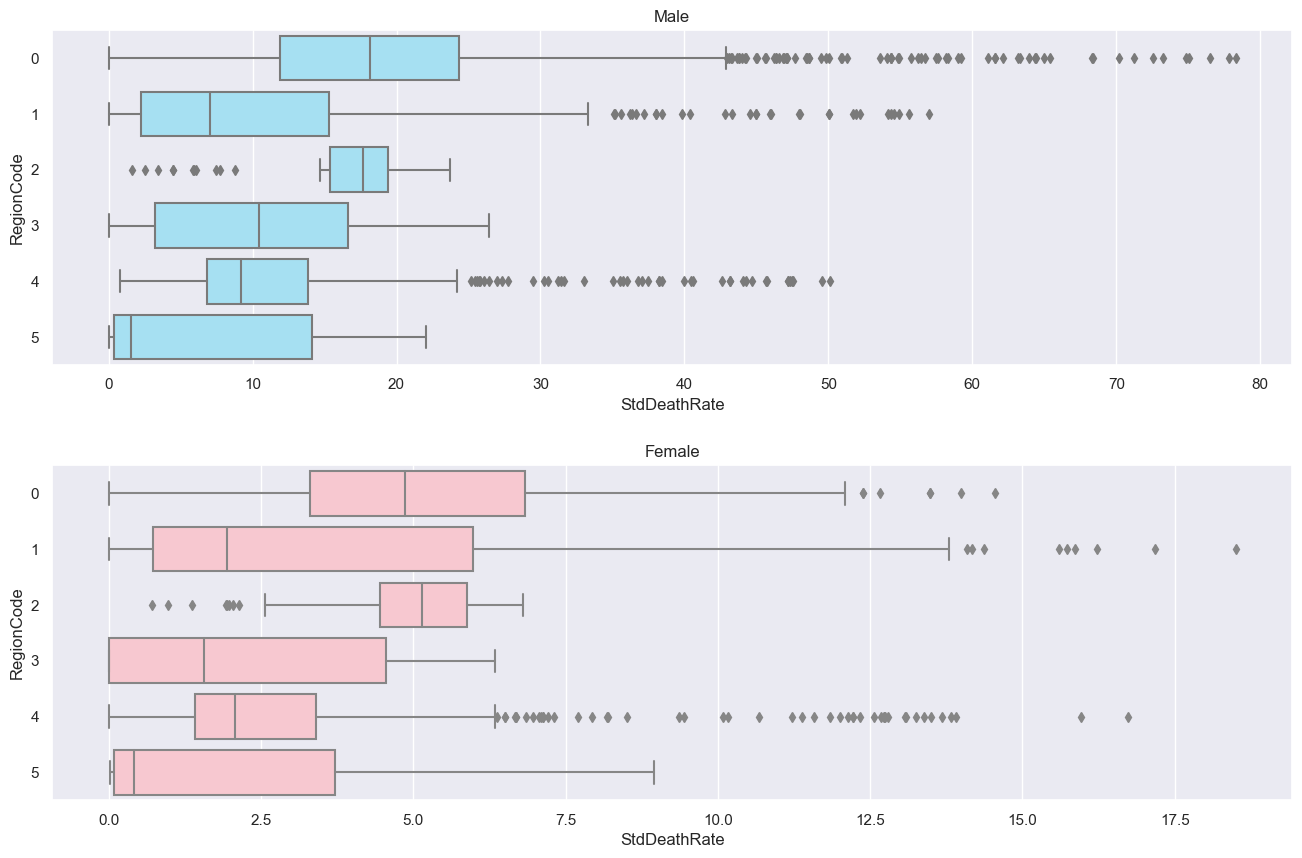

In [15]:
plt.figure(figsize=(16,10))
ax1 = plt.subplot(2,1,1)
ax1.set_title("Male")
sb.boxplot(data=maleData, y='RegionCode', x='StdDeathRate', color = "#99e6ff")

ax2 =plt.subplot(2,1,2)
ax2.set_title("Female")
sb.boxplot(data=femaleData, y='RegionCode', x='StdDeathRate', color = "pink")
plt.subplots_adjust(hspace=0.3)

median_gdp_per_capita = data.groupby('RegionCode')['GDPPerCapita'].median()
print("Median GDPPerCapita for each RegionCode:")
print(median_gdp_per_capita)

Different regions have differing medians suicide rates, but both male and female trend for median suicide rates generally stay the same when all the values are normalized. 

For regions with higher Median GDP, the median Suicide Rate seems to be higher.



<span style='font-size:xx-large'>**Exploring Correlation between all Columns after Splitting by Sex and Region**</span>



<span style='font-size:x-large'>**Male**</span>


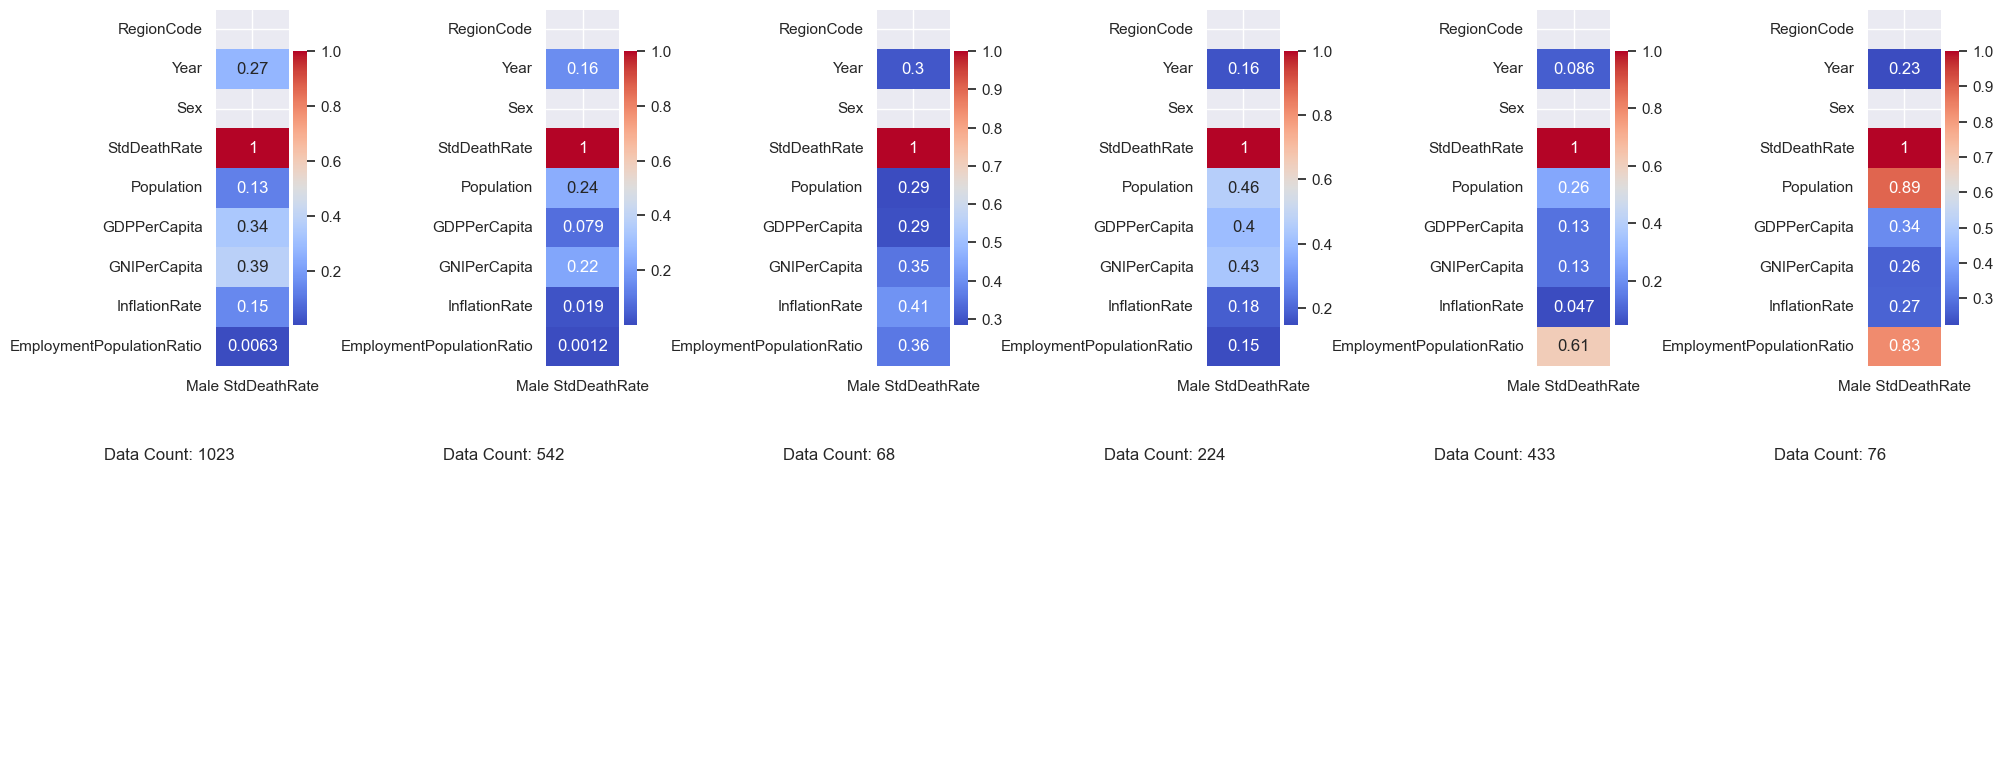

In [16]:
plt.figure(figsize=(20,8))
subplot_x = 2

#all correlation matrixes

plt.subplot(subplot_x,6,1)
correlation_matrix = maleData[maleData['RegionCode']==0].corr().abs()
correlation_matrix.rename(columns={'StdDeathRate': 'Male StdDeathRate'}, inplace=True)
sb.heatmap(correlation_matrix[['Male StdDeathRate']], annot=True, cmap='coolwarm')
plt.subplot(subplot_x,6,2)
correlation_matrix = maleData[maleData['RegionCode']==1].corr().abs()
correlation_matrix.rename(columns={'StdDeathRate': 'Male StdDeathRate'}, inplace=True)
sb.heatmap(correlation_matrix[['Male StdDeathRate']], annot=True, cmap='coolwarm')
plt.subplot(subplot_x,6,3)
correlation_matrix = maleData[maleData['RegionCode']==2].corr().abs()
correlation_matrix.rename(columns={'StdDeathRate': 'Male StdDeathRate'}, inplace=True)
sb.heatmap(correlation_matrix[['Male StdDeathRate']], annot=True, cmap='coolwarm')
plt.subplot(subplot_x,6,4)
correlation_matrix = maleData[maleData['RegionCode']==3].corr().abs()
correlation_matrix.rename(columns={'StdDeathRate': 'Male StdDeathRate'}, inplace=True)
sb.heatmap(correlation_matrix[['Male StdDeathRate']], annot=True, cmap='coolwarm')
plt.subplot(subplot_x,6,5)
correlation_matrix = maleData[maleData['RegionCode']==4].corr().abs()
correlation_matrix.rename(columns={'StdDeathRate': 'Male StdDeathRate'}, inplace=True)
sb.heatmap(correlation_matrix[['Male StdDeathRate']], annot=True, cmap='coolwarm')
plt.subplot(subplot_x,6,6)
correlation_matrix = maleData[maleData['RegionCode']==5].corr().abs()
correlation_matrix.rename(columns={'StdDeathRate': 'Male StdDeathRate'}, inplace=True)
sb.heatmap(correlation_matrix[['Male StdDeathRate']], annot=True, cmap='coolwarm')

#Information under plots
plt.subplot(subplot_x,6,7)
data_desc = "Data Count: " + str(maleData[maleData['RegionCode']==0].count()[0])
plt.text(0.2, 0.9, data_desc, ha='right', va='top')
plt.axis('off')
plt.subplot(subplot_x,6,8)
data_desc = "Data Count: " + str(maleData[maleData['RegionCode']==1].count()[0])
plt.text(0.2, 0.9, data_desc, ha='right', va='top')
plt.axis('off')
plt.subplot(subplot_x,6,9)
data_desc = "Data Count: " + str(maleData[maleData['RegionCode']==2].count()[0])
plt.text(0.2, 0.9, data_desc, ha='right', va='top')
plt.axis('off')
plt.subplot(subplot_x,6,10)
data_desc = "Data Count: " + str(maleData[maleData['RegionCode']==3].count()[0])
plt.text(0.2, 0.9, data_desc, ha='right', va='top')
plt.axis('off')
plt.subplot(subplot_x,6,11)
data_desc = "Data Count: " + str(maleData[maleData['RegionCode']==4].count()[0])
plt.text(0.2, 0.9, data_desc, ha='right', va='top')
plt.axis('off')
plt.subplot(subplot_x,6,12)
data_desc = "Data Count: " + str(maleData[maleData['RegionCode']==5].count()[0])
plt.text(0.2, 0.9, data_desc, ha='right', va='top')
plt.axis('off')

plt.tight_layout()
plt.show()



<span style='font-size:x-large'>**Female**</span>


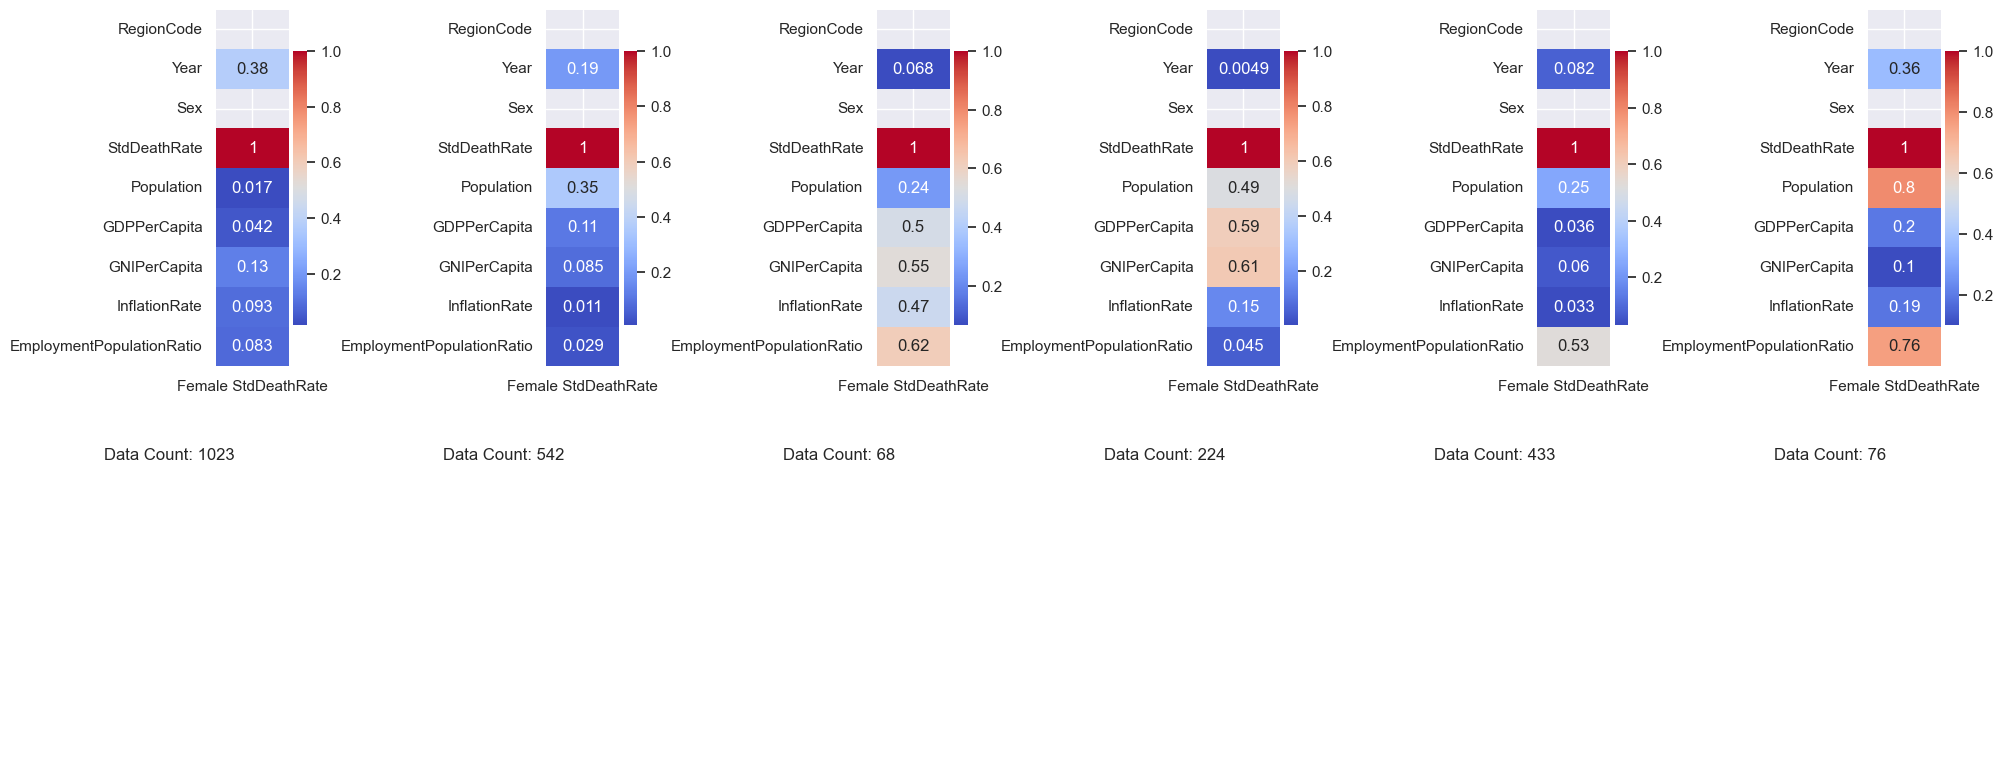

In [17]:
plt.figure(figsize=(20,8))
subplot_x = 2

#all correlation matrixes

plt.subplot(subplot_x,6,1)
correlation_matrix = femaleData[femaleData['RegionCode']==0].corr().abs()
correlation_matrix.rename(columns={'StdDeathRate': 'Female StdDeathRate'}, inplace=True)
sb.heatmap(correlation_matrix[['Female StdDeathRate']], annot=True, cmap='coolwarm')
plt.subplot(subplot_x,6,2)
correlation_matrix = femaleData[femaleData['RegionCode']==1].corr().abs()
correlation_matrix.rename(columns={'StdDeathRate': 'Female StdDeathRate'}, inplace=True)
sb.heatmap(correlation_matrix[['Female StdDeathRate']], annot=True, cmap='coolwarm')
plt.subplot(subplot_x,6,3)
correlation_matrix = femaleData[femaleData['RegionCode']==2].corr().abs()
correlation_matrix.rename(columns={'StdDeathRate': 'Female StdDeathRate'}, inplace=True)
sb.heatmap(correlation_matrix[['Female StdDeathRate']], annot=True, cmap='coolwarm')
plt.subplot(subplot_x,6,4)
correlation_matrix = femaleData[femaleData['RegionCode']==3].corr().abs()
correlation_matrix.rename(columns={'StdDeathRate': 'Female StdDeathRate'}, inplace=True)
sb.heatmap(correlation_matrix[['Female StdDeathRate']], annot=True, cmap='coolwarm')
plt.subplot(subplot_x,6,5)
correlation_matrix = femaleData[femaleData['RegionCode']==4].corr().abs()
correlation_matrix.rename(columns={'StdDeathRate': 'Female StdDeathRate'}, inplace=True)
sb.heatmap(correlation_matrix[['Female StdDeathRate']], annot=True, cmap='coolwarm')
plt.subplot(subplot_x,6,6)
correlation_matrix = femaleData[femaleData['RegionCode']==5].corr().abs()
correlation_matrix.rename(columns={'StdDeathRate': 'Female StdDeathRate'}, inplace=True)
sb.heatmap(correlation_matrix[['Female StdDeathRate']], annot=True, cmap='coolwarm')

#Information under plots
plt.subplot(subplot_x,6,7)
data_desc = "Data Count: " + str(femaleData[femaleData['RegionCode']==0].count()[0])
plt.text(0.2, 0.9, data_desc, ha='right', va='top')
plt.axis('off')
plt.subplot(subplot_x,6,8)
data_desc = "Data Count: " + str(femaleData[femaleData['RegionCode']==1].count()[0])
plt.text(0.2, 0.9, data_desc, ha='right', va='top')
plt.axis('off')
plt.subplot(subplot_x,6,9)
data_desc = "Data Count: " + str(femaleData[femaleData['RegionCode']==2].count()[0])
plt.text(0.2, 0.9, data_desc, ha='right', va='top')
plt.axis('off')
plt.subplot(subplot_x,6,10)
data_desc = "Data Count: " + str(femaleData[femaleData['RegionCode']==3].count()[0])
plt.text(0.2, 0.9, data_desc, ha='right', va='top')
plt.axis('off')
plt.subplot(subplot_x,6,11)
data_desc = "Data Count: " + str(femaleData[femaleData['RegionCode']==4].count()[0])
plt.text(0.2, 0.9, data_desc, ha='right', va='top')
plt.axis('off')
plt.subplot(subplot_x,6,12)
data_desc = "Data Count: " + str(femaleData[femaleData['RegionCode']==5].count()[0])
plt.text(0.2, 0.9, data_desc, ha='right', va='top')
plt.axis('off')

plt.tight_layout()
plt.show()

Region Code 2 and 5 do not have enough data for us to perform machine learning techniques, thus those values will be not be used.

As Region code 0 \(Europe\) and 1 \(Asia\), has the highest amount of data for us to train, we will be using data from Europe and Asia for our model 




<span style='font-size:xx-large'>**Exploring GNIPerCapita and GDPPerCapita For Males in Europe and Asia**</span>


Correlation between StdDeathRate and GDPPerCapita for Males in Europe:
              StdDeathRate  GNIPerCapita  GDPPerCapita
StdDeathRate      1.000000      0.386397      0.342518
GNIPerCapita      0.386397      1.000000      0.926291
GDPPerCapita      0.342518      0.926291      1.000000


<function matplotlib.pyplot.show(close=None, block=None)>

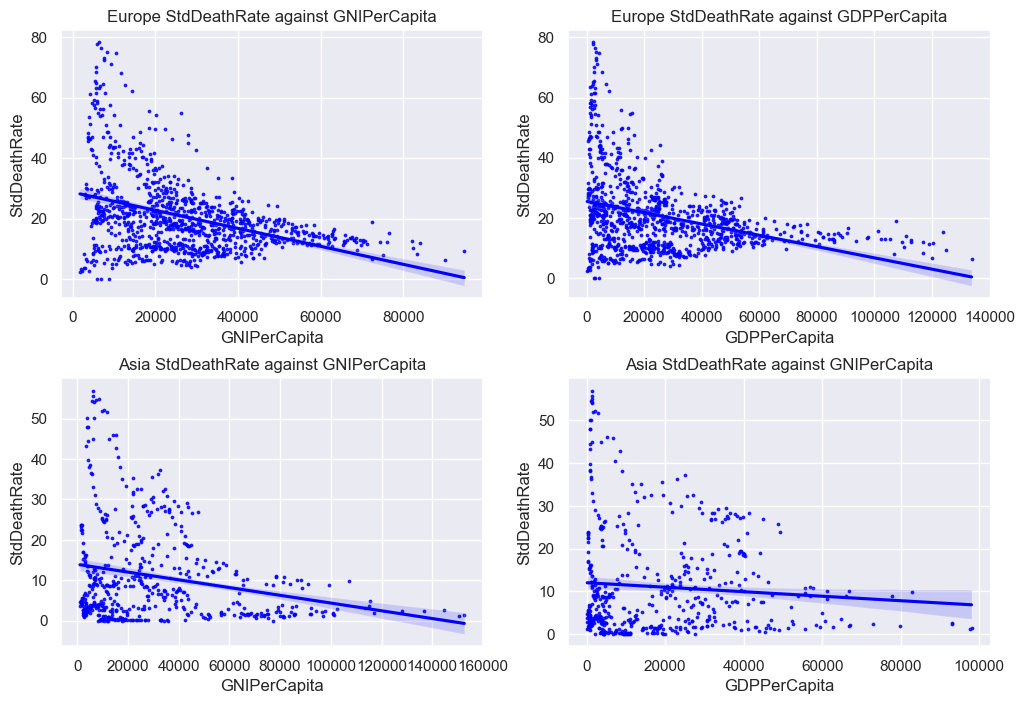

In [18]:
#Correlation
print("Correlation between StdDeathRate and GDPPerCapita for Males in Europe:")

exploring = maleData[maleData['RegionCode']==0]
correlation_matrix = exploring[['StdDeathRate','GNIPerCapita','GDPPerCapita']].corr().abs()
print(correlation_matrix)


#Scatterplot
plt.figure(figsize=(12, 8))
ax11 = plt.subplot(2,2,1)
ax11.set_title("Europe StdDeathRate against GNIPerCapita")
sb.regplot(data=maleData[maleData['RegionCode'] == 0], x="GNIPerCapita", y="StdDeathRate", color='blue', scatter_kws={'s': 3})

ax12 = plt.subplot(2,2,2)
ax12.set_title("Europe StdDeathRate against GDPPerCapita")
sb.regplot(data=maleData[maleData['RegionCode'] == 0], x="GDPPerCapita", y="StdDeathRate", color='blue', scatter_kws={'s': 3})

ax21 = plt.subplot(2,2,3)
ax21.set_title("Asia StdDeathRate against GNIPerCapita")
sb.regplot(data=maleData[maleData['RegionCode'] == 1], x="GNIPerCapita", y="StdDeathRate", color='blue', scatter_kws={'s': 3})

ax22 = plt.subplot(2,2,4)
ax22.set_title("Asia StdDeathRate against GNIPerCapita")
sb.regplot(data=maleData[maleData['RegionCode'] == 1], x="GDPPerCapita", y="StdDeathRate", color='blue', scatter_kws={'s': 3})

plt.subplots_adjust(hspace=0.3)

plt.grid(True)
plt.show

We can tell that the higher the GDPPerCapita or GNIPerCapita, the less variance in suicide rates.



<span style='font-size:xx-large'>**Exploring GNIPerCapita and Population For Females in Europe and Asia**</span>


Correlation between StdDeathRate, GNIPerCapita and Population for females in Europe:
              StdDeathRate  GNIPerCapita  Population
StdDeathRate      1.000000      0.133688    0.017065
GNIPerCapita      0.133688      1.000000    0.056387
Population        0.017065      0.056387    1.000000
Correlation between StdDeathRate, GNIPerCapita and Population for females in Asia:
              StdDeathRate  GNIPerCapita  Population
StdDeathRate      1.000000      0.084600    0.351284
GNIPerCapita      0.084600      1.000000    0.196137
Population        0.351284      0.196137    1.000000


<function matplotlib.pyplot.show(close=None, block=None)>

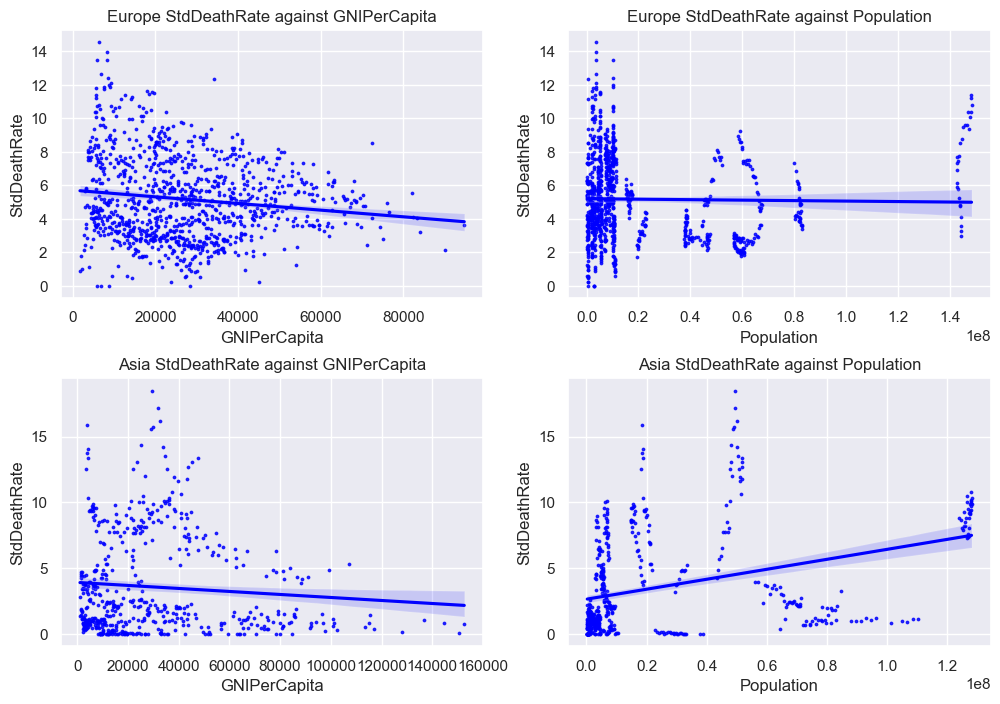

In [19]:
#Correlation

print("Correlation between StdDeathRate, GNIPerCapita and Population for females in Europe:")
exploring = femaleData[femaleData['RegionCode']==0]
correlation_matrix = exploring[['StdDeathRate','GNIPerCapita','Population']].corr().abs()
print(correlation_matrix)

print("=================================================================")

print("Correlation between StdDeathRate, GNIPerCapita and Population for females in Asia:")
exploring = femaleData[femaleData['RegionCode']==1]
correlation_matrix = exploring[['StdDeathRate','GNIPerCapita','Population']].corr().abs()
print(correlation_matrix)


#Scatterplot
plt.figure(figsize=(12, 8))
ax11 = plt.subplot(2,2,1)
ax11.set_title("Europe StdDeathRate against GNIPerCapita")
sb.regplot(data=femaleData[femaleData['RegionCode'] == 0], x="GNIPerCapita", y="StdDeathRate", color='blue', scatter_kws={'s': 3})

ax12 = plt.subplot(2,2,2)
ax12.set_title("Europe StdDeathRate against Population")
sb.regplot(data=femaleData[femaleData['RegionCode'] == 0], x="Population", y="StdDeathRate", color='blue', scatter_kws={'s': 3})

ax21 = plt.subplot(2,2,3)
ax21.set_title("Asia StdDeathRate against GNIPerCapita")
sb.regplot(data=femaleData[femaleData['RegionCode'] == 1], x="GNIPerCapita", y="StdDeathRate", color='blue', scatter_kws={'s': 3})

ax22 = plt.subplot(2,2,4)
ax22.set_title("Asia StdDeathRate against Population")
sb.regplot(data=femaleData[femaleData['RegionCode'] == 1], x="Population", y="StdDeathRate", color='blue', scatter_kws={'s': 3})

plt.subplots_adjust(hspace=0.3)

plt.grid(True)
plt.show

No correlation can be visually observerved from both GNIPerCapita and Population against StdDeathRate for Females

---------------------------------------------------------------------------



<span style='font-size:xxx-large'>**Regression Modelling**</span>


In [20]:
#importing dependencies
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import plot_tree
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor

As we have the most data with region 0, we will be using the suicide data in Europe to build our models.

<span style='font-size:xx-large'>**Outlier Removal**</span>


In [21]:
print("Male Data from Europe before Outlier Removal: ", maleData[maleData['RegionCode']== 0].shape)
maleData = removeOutliers(maleData[maleData['RegionCode']== 0], 'StdDeathRate') #overwrite maleData.
maleData = removeOutliers(maleData, 'GNIPerCapita')
print("Male Data from Europe after Outlier Removal: ", maleData.shape)

Male Data from Europe before Outlier Removal:  (1023, 9)
Male Data from Europe after Outlier Removal:  (936, 9)


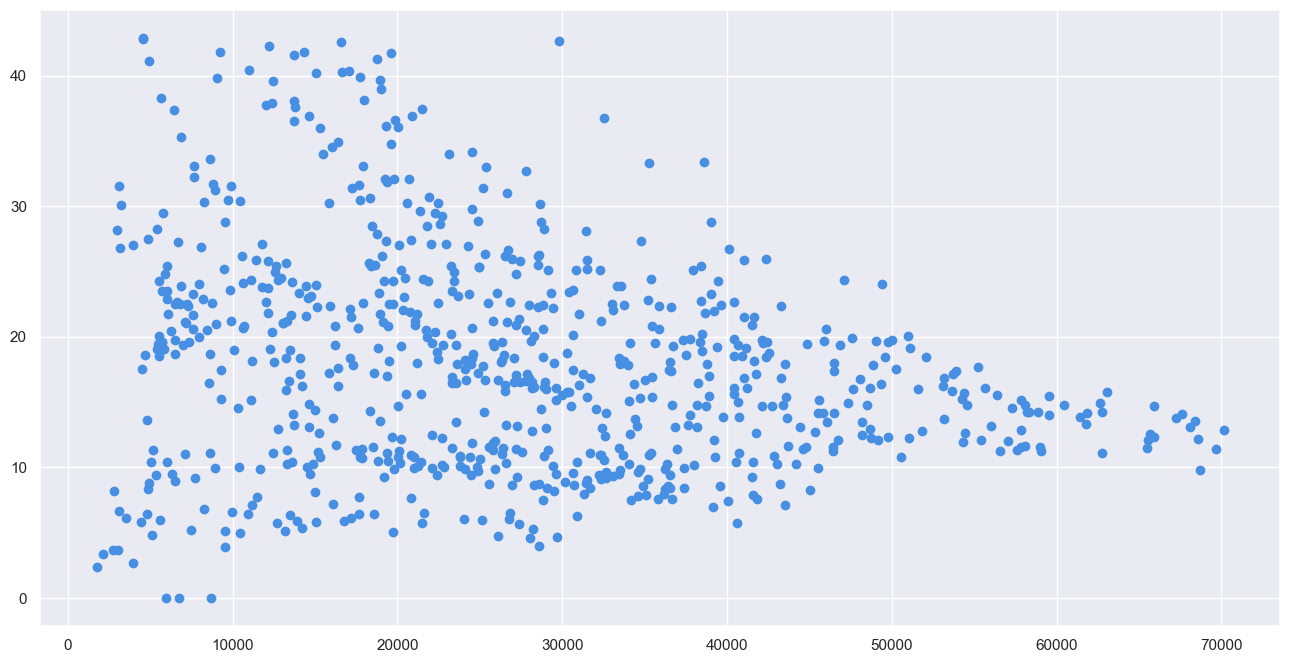

In [22]:
def visualize_train_set(data, features, target, test_size=0.2, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(data[[features]], data[[target]], test_size=test_size, random_state=random_state)
    plt.figure(figsize=(16, 8))
    plt.scatter(X_train, y_train, color="#468fe3", label="Actual")
    plt.show()

visualize_train_set(maleData, features = 'GNIPerCapita', target = 'StdDeathRate')


In [23]:
def linear_regression(data, features, target, test_size=0.2, random_state=42):
    """
    Perform linear regression on the provided data.

    Parameters:
    - data: DataFrame, the dataset containing both features and target variable.
    - features: list, names of the features to be used for regression.
    - target: str, name of the target variable.
    - test_size: float, optional (default=0.2), proportion of the dataset to include in the test split.
    - random_state: int, optional (default=42), controls the randomness of the dataset.

    Returns:
    - mse: float, Mean Squared Error of the model.
    - r_squared: float, R-squared value of the model.
    """
    # Splitting the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(data[[features]], data[[target]], test_size=test_size, random_state=random_state)

    # Creating the linear regression model
    linreg = LinearRegression()

    # Fitting the model to the training data
    linreg.fit(X_train, y_train)

    # Making predictions on the training data
    y_train_pred = linreg.predict(X_train)

    # Making predictions on the testing data
    y_pred = linreg.predict(X_test)

    # Evaluating the model
    mse_train = mean_squared_error(y_train, y_train_pred)
    r_squared_train = r2_score(y_train, y_train_pred)

    mse_test = mean_squared_error(y_test, y_pred)
    r_squared_test = r2_score(y_test, y_pred)

    # Plotting the actual vs predicted values for the test set
    plt.figure(figsize=(16, 8))
    plt.scatter(X_test, y_test, color="green", label="Actual")
    plt.scatter(X_test, y_pred, color="red", label="Predicted")
    plt.show()

    return mse_test, r_squared_test

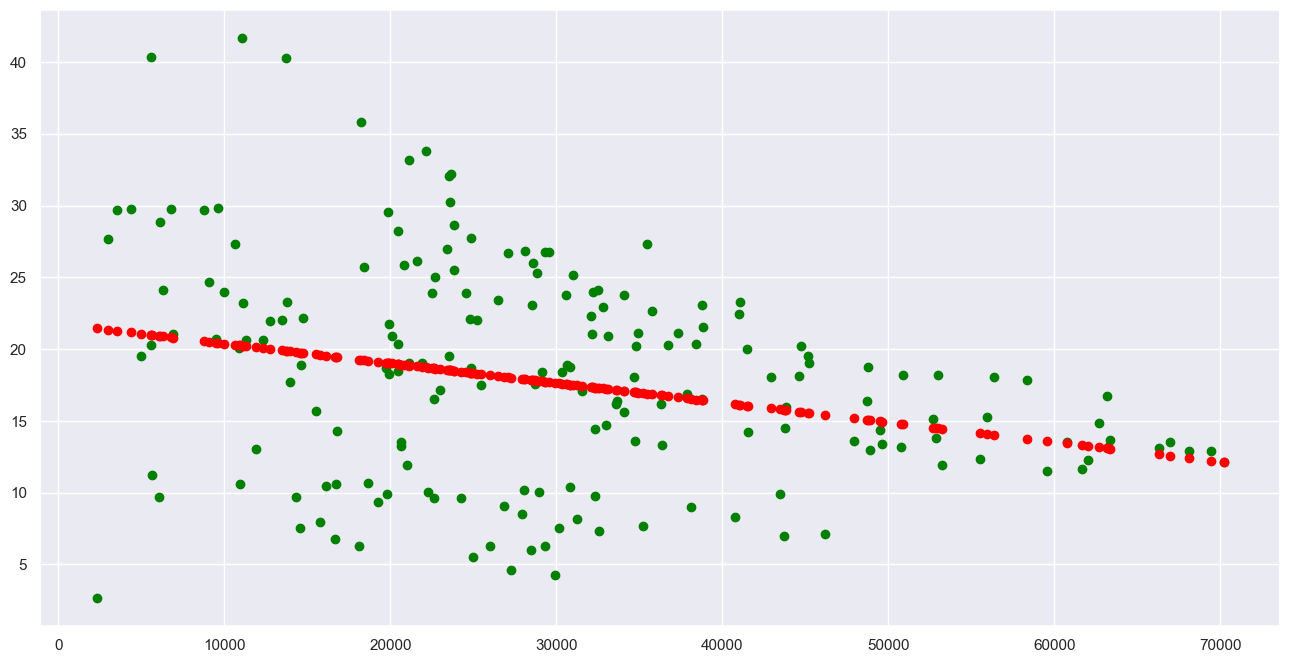

MSE:  50.93107395631876
R-squared:  0.09322070617247313


In [24]:
mse, rsq = linear_regression(maleData, features = 'GNIPerCapita', target = 'StdDeathRate')
print("MSE: ", mse)
print("R-squared: ", rsq)

<span style='font-size:xx-large'>**Decision Tree Regression**</span>


In [25]:
def decision_tree_regression(data, features, target, test_size=0.2, max_depth=3, random_state=42):
    """
    Perform decision tree regression on the provided data.

    Parameters:
    - data: DataFrame, the dataset containing both features and target variable.
    - features: list, names of the features to be used for regression.
    - target: str, name of the target variable.
    - test_size: float, optional (default=0.2), proportion of the dataset to include in the test split.
    - max_depth: int, optional (default=3), the maximum depth of the tree.
    - random_state: int, optional (default=42), controls the randomness of the dataset.

    Returns:
    - mse: float, Mean Squared Error of the model.
    - r_squared: float, R-squared value of the model.
    """
    # Splitting the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(data[features], data[target], test_size=test_size, random_state=random_state)

    # Creating the decision tree regressor model
    model = DecisionTreeRegressor(max_depth=max_depth)

    # Fitting the model to the training data
    model.fit(X_train, y_train)

    # Making predictions on the testing data
    y_pred = model.predict(X_test)

    # Evaluating the model
    mse = mean_squared_error(y_test, y_pred)
    r_squared = r2_score(y_test, y_pred)

    # Plotting the decision tree
    plt.figure(figsize=(16, 8))
    plot_tree(model, filled=True, feature_names=features)
    plt.show()

    # Plotting the actual vs predicted values
    f = plt.figure(2, figsize=(16, 8))
    plt.scatter(X_test, y_test, color="green", label="Actual")
    plt.scatter(X_test, y_pred, color="red", label="Predicted")
    plt.show()

    return mse, r_squared

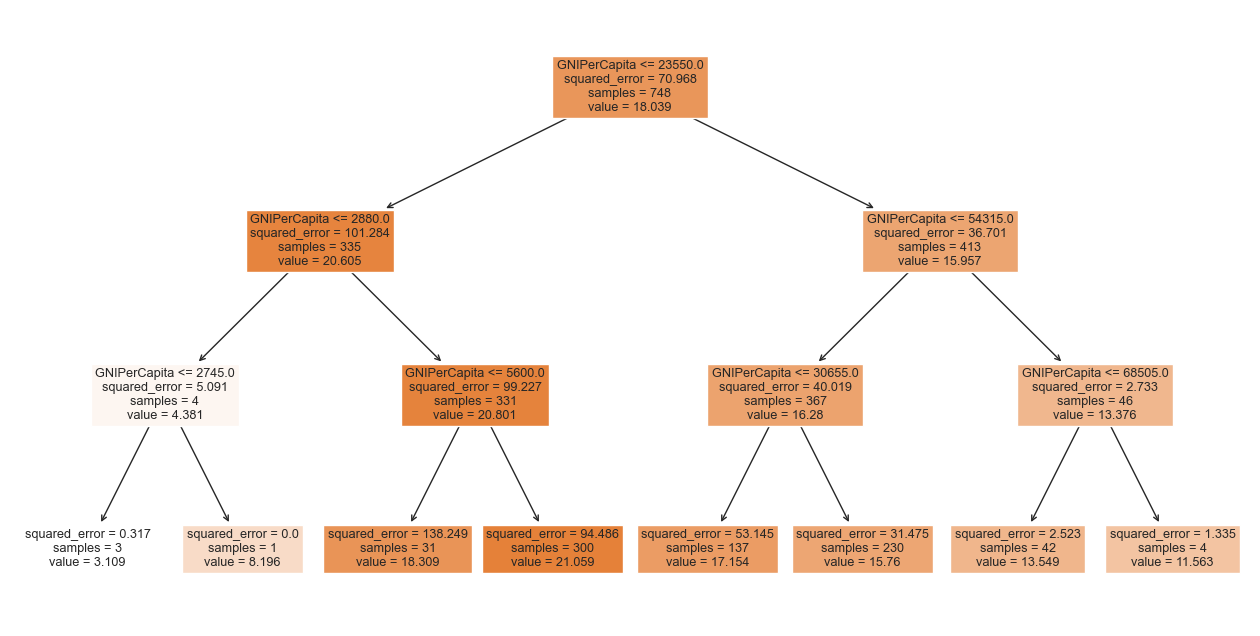

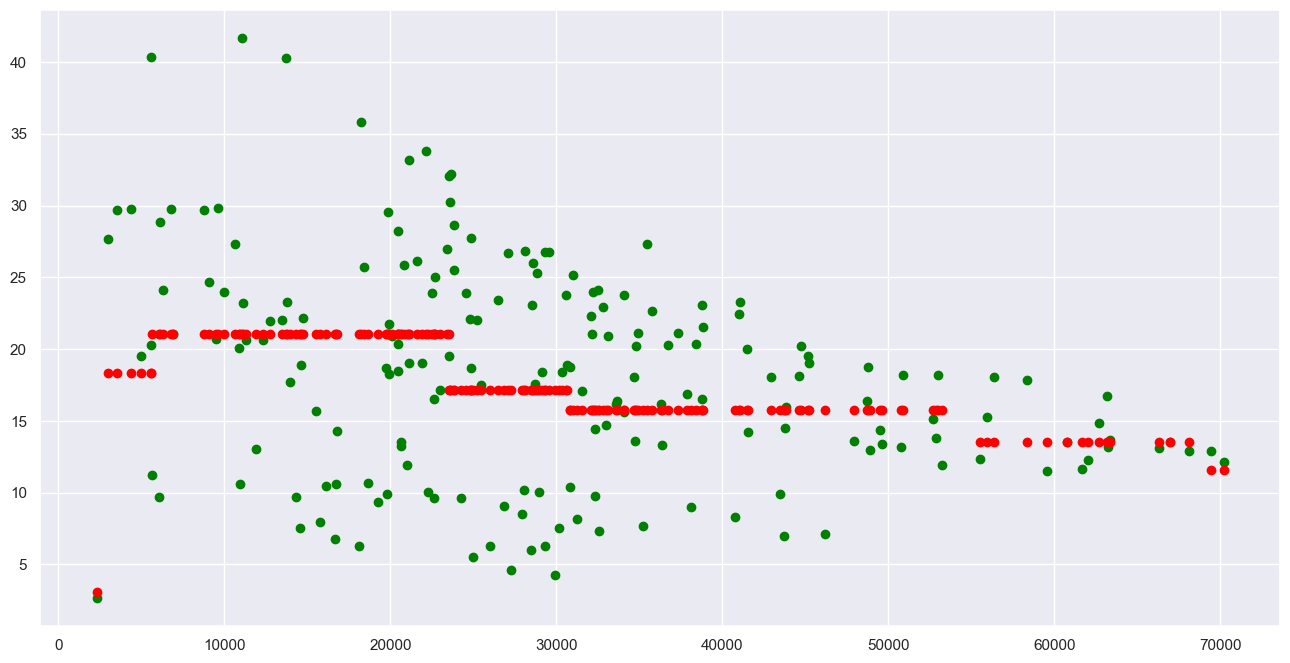

MSE:  52.54829174503279
R-squared:  0.06442768276846755


In [26]:
mse, rsq = decision_tree_regression(data = maleData, features = ["GNIPerCapita"], target = "StdDeathRate")
print("MSE: ", mse)
print("R-squared: ", rsq)

<span style='font-size:xx-large'>**Polynomial Regression**</span>


In [27]:
def polynomial_regression(data, features, target, test_size=0.3, degree=2, random_state= 42):
    """
    Perform polynomial regression on the provided data.

    Parameters:
    - data: DataFrame, the dataset containing both features and target variable.
    - target_feature: str, name of the target variable.
    - predictor_features: list, names of the predictor variables.
    - test_size: float, optional (default=0.3), proportion of the dataset to include in the test split.
    - degree: int, optional (default=2), degree of the polynomial features.
    - random_state: int, optional (default=42), controls the randomness of the dataset.

    Returns:
    - mse: float, Mean Squared Error of the model.
    - r2: float, R-squared value of the model.
    """
    # Splitting the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(data[[features]], data[[target]], test_size=test_size, random_state=random_state)

    # Create a polynomial features object with the specified degree
    poly = PolynomialFeatures(degree=degree)

    # Transform the predictor variables to polynomial features
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)

    # Create a linear regression object
    lin_reg = LinearRegression()

    # Fit the model to the training data
    lin_reg.fit(X_train_poly, y_train)

    # Predict the response variable for the test data
    y_pred = lin_reg.predict(X_test_poly)

    # Calculate the mean squared error of the model
    mse = mean_squared_error(y_test, y_pred)
    print("Mean Squared Error:", mse)

    # Calculate the R-squared value of the model
    r2 = r2_score(y_test, y_pred)
    print("R-squared:", r2)

    # Plot the Predictions
    f = plt.figure(2, figsize=(16, 8))
    plt.scatter(X_test[features], y_test, color="green", label="Actual")
    plt.scatter(X_test[features], y_pred, color="red", label="Predicted")
    plt.show()

    return mse, r2

Mean Squared Error: 56.95847342421202
R-squared: 0.08129898522424406


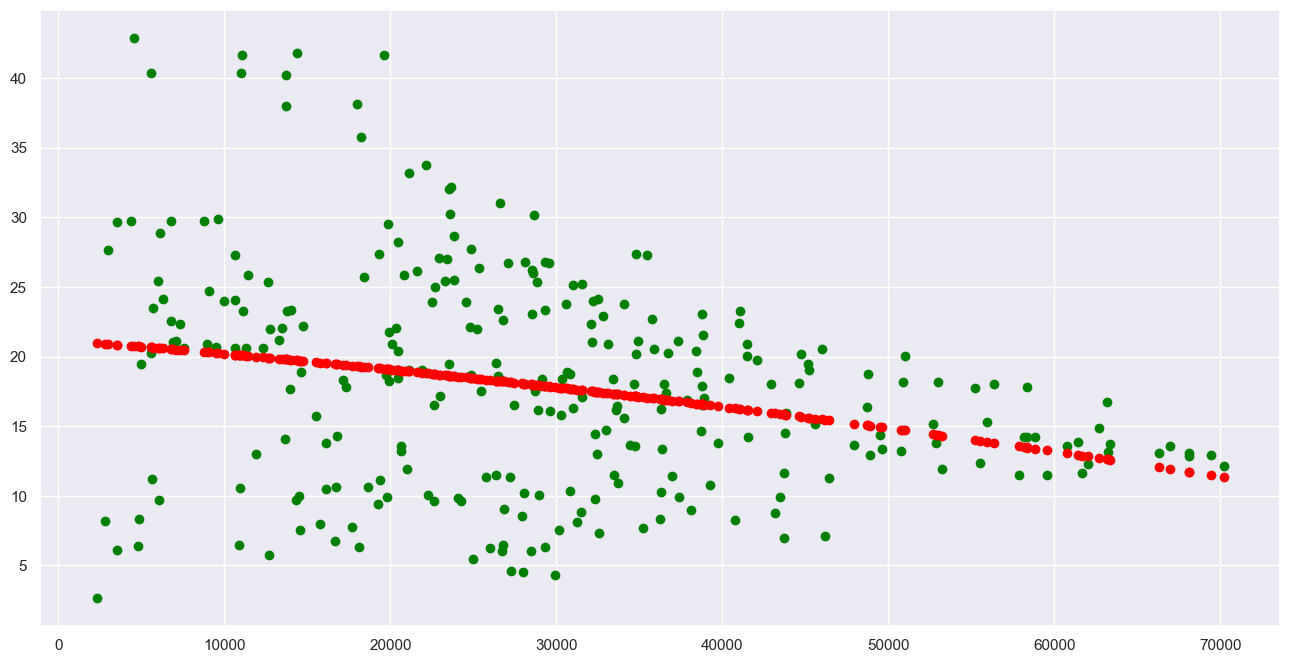

MSE:  56.95847342421202
R-squared:  0.08129898522424406


In [28]:
mse, rsq = polynomial_regression(data = maleData, features = "GNIPerCapita", target = "StdDeathRate")
print("MSE: ", mse)
print("R-squared: ", rsq)

<span style='font-size:xx-large'>**Random Forest Regression**</span>


In [29]:
def random_forest_regression(data, features, target, test_size=0.2, n_estimators=100, random_state=42):
    """
    Perform random forest regression on the provided data.

    Parameters:
    - data: DataFrame, the dataset containing both features and target variable.
    - target_feature: str, name of the target variable.
    - predictor_features: list, names of the predictor variables.
    - test_size: float, optional (default=0.2), proportion of the dataset to include in the test split.
    - n_estimators: int, optional (default=100), number of trees in the forest.
    - random_state: int, optional (default=42), controls the randomness of the dataset.

    Returns:
    - mse: float, Mean Squared Error of the model.
    - r2: float, R-squared value of the model.
    """
    # Splitting the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(data[[features]], data[[target]], test_size=test_size, random_state=random_state)

    # Create a random forest regressor object with the specified number of trees
    rf_reg = RandomForestRegressor(n_estimators=n_estimators, random_state=random_state)

    # Fit the model to the training data
    rf_reg.fit(X_train, y_train)

    # Predict the response variable for the test data
    y_pred = rf_reg.predict(X_test)

    # Plot the Predictions
    f = plt.figure(2, figsize=(16, 8))
    plt.scatter(X_test[features], y_test, color="green", label="Actual")
    plt.scatter(X_test[features], y_pred, color="red", label="Predicted")
    plt.legend()
    plt.show()


    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    return mse, r2

C:\Users\usama\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



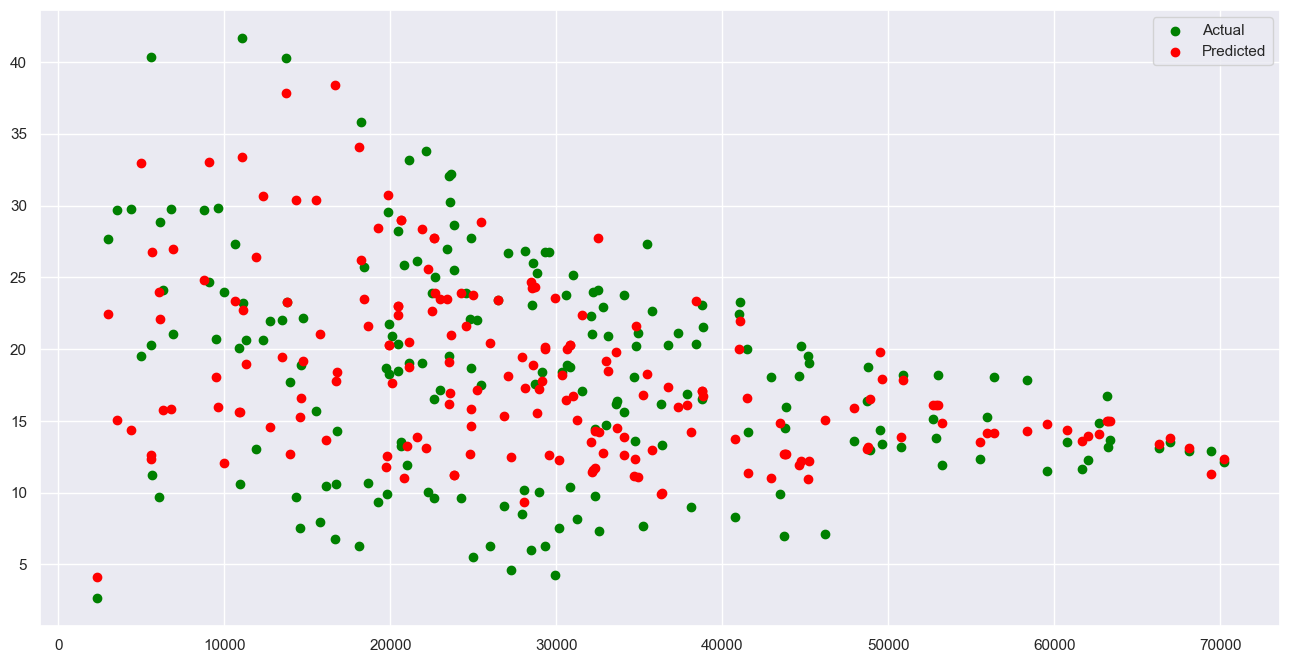

MSE:  81.05170722047271
R-squared:  -0.4430484992311343


In [30]:
mse, rsq = random_forest_regression(data = maleData, features = "GNIPerCapita", target = "StdDeathRate")
print("MSE: ", mse)
print("R-squared: ", rsq)

<span style='font-size:xx-large'>**Gradient Boosting Regression**</span>


In [31]:

def gradient_boosting_regression(data, features, target, test_size=0.2, n_estimators=100, random_state=42):
    """
    Perform gradient boosting regression on the provided data.

    Parameters:
    - data: DataFrame, the dataset containing both features and target variable.
    - target_feature: str, name of the target variable.
    - predictor_features: list, names of the predictor variables.
    - test_size: float, optional (default=0.2), proportion of the dataset to include in the test split.
    - n_estimators: int, optional (default=100), number of boosting stages.
    - random_state: int, optional (default=42), controls the randomness of the dataset.

    Returns:
    - mse: float, Mean Squared Error of the model.
    - r2: float, R-squared value of the model.
    """
    # Splitting the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(data[[features]], data[[target]], test_size=test_size, random_state=random_state)

    # Create a gradient boosting regressor object with the specified number of trees
    gb_reg = GradientBoostingRegressor(n_estimators=n_estimators, random_state=random_state)

    # Fit the model to the training data
    gb_reg.fit(X_train, y_train)

    # Predict the response variable for the test data
    y_pred = gb_reg.predict(X_test)

    # Plot the Predictions
    f = plt.figure(2, figsize=(16, 8))
    plt.scatter(X_test[features], y_test, color="green", label="Actual")
    plt.scatter(X_test[features], y_pred, color="red", label="Predicted")

    plt.legend()
    plt.show()

    # Calculate the mean squared error of the model
    mse = mean_squared_error(y_test, y_pred)

    # Calculate the R-squared value of the model
    r2 = r2_score(y_test, y_pred)

    return mse, r2

C:\Users\usama\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



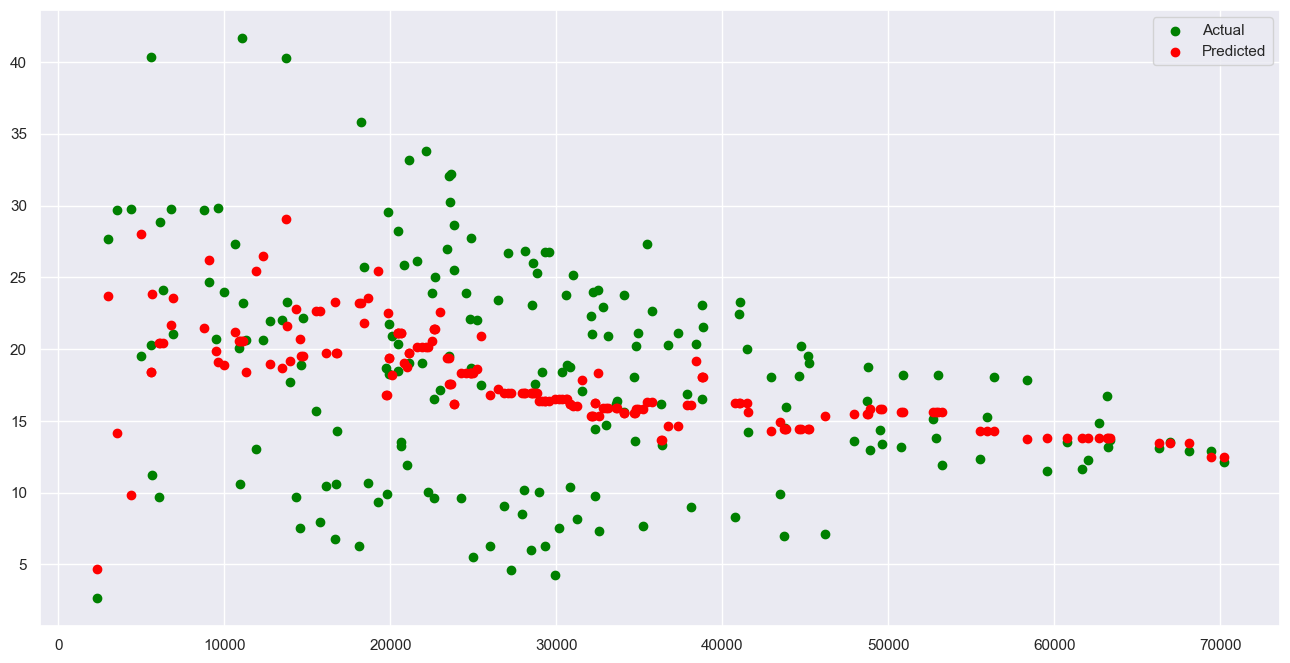

MSE:  55.4481335040054
R-squared:  0.012798760420041022


In [32]:
mse, rsq = gradient_boosting_regression(data = maleData, features = "GNIPerCapita", target = "StdDeathRate")
print("MSE: ", mse)
print("R-squared: ", rsq)

#### Which Models Were Successful and Which Were Not ?

By the results of the 5 models that were used, we decided that 3 models performed significantly better than the rest;
>Linear Regression (best)
>
>Polynomial Regression (2nd best)
>
>Decision Tree (3rd best)

The other 2 models that we attempted to use performed much worse compared to Linear Regression and Polynomial Regression
- Random Forest Regression by far produced the worst R^2 and MSE output
- Gradient Boosting was bad but not as bad as random forest

Polynomial Regression > Decision Tree > Linear Regression  >Gradient Boosting > Random Forest

--------------------------------------------------------------

<span style='font-size:xxx-large'>**Final Insights and Conclusion**</span>


## Data Driven Insights & Conclusion:
#### Peak and Fluctuations in Global Suicide Rates:
1. Peak and Fluctuations in Global Suicide Rates:
2. Global suicide rates have shown fluctuations over the years, peaking around 1997, decreasing subsequently, and then peaking again in 2021.

#### Consistent Gender-Specific Trends:
1. Despite the stability in global suicide rates, the trend in suicide rates between genders has remained consistent over the years.
2. Recognizing the distinct factors influencing male and female suicide rates is essential.

#### Peak in Global Suicide Rates:
1. An analysis of global suicide rates reveals a notable peak around 1997. This peak serves as a significant point of interest for further investigation into the societal, economic, and psychological factors that may have contributed to this surge in suicides.


### Socioeconomic Factors:

## Regional Variations in Suicide Trends:
1. Regional variations suggest that sociocultural factors, access to mental health services, and other variables may play significant roles in shaping these trends.
2. By incorporating regional data into predictive models, we can develop more accurate and robust algorithms for forecasting suicide rates. These models can help identify high-risk areas and target interventions more effectively, ultimately leading to more targeted and efficient allocation of resources for suicide prevention efforts.

## Economic Prosperity and Suicide Rates:
1. Our analysis revealed a strong correlation between economic prosperity, as measured by Gross National Income (GNI), and suicide rates.
2. Specifically, we found that as a country's GNIPerCapita increases, the variance of suicide rates decreases, indicating a more predictable trend.
3. Moreover, our analysis showed that suicide rate tends to decrease as GNIPerCapita increases.

### Conclusion
1. Gender is a major factor when trying to build a model to predict the suicide rate of a country.
2. We found that while there is a correlation between economic prosperity and suicide rates, regional variations suggest that other factors, such as sociocultural influences and access to mental health services, also play significant roles in shaping these trends.
3. Specifically, indicators such as GNIPerCapita and GDPPerCapita showed significant correlations with male suicide rates. However, correlations between socioeconomic factors and female suicide rates were less pronounced, indicating the need for further investigation.
4. Based on findings, we can suggest that the suicide rates get more unpredictable a country gets poorer, but lower and more predictable when a country is rich.
